**Chapter 2 – End-to-end Machine Learning project**

In [82]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Get the Data

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

## Download the Data

In [83]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

## Take a Quick Look at the Data Structure

In [84]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [85]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [86]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [87]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The following cell is not shown either in the book. It creates the `images/end_to_end_project` folder (if it doesn't already exist), and it defines the `save_fig()` function which is used through this notebook to save the figures in high-res for the book.

In [88]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

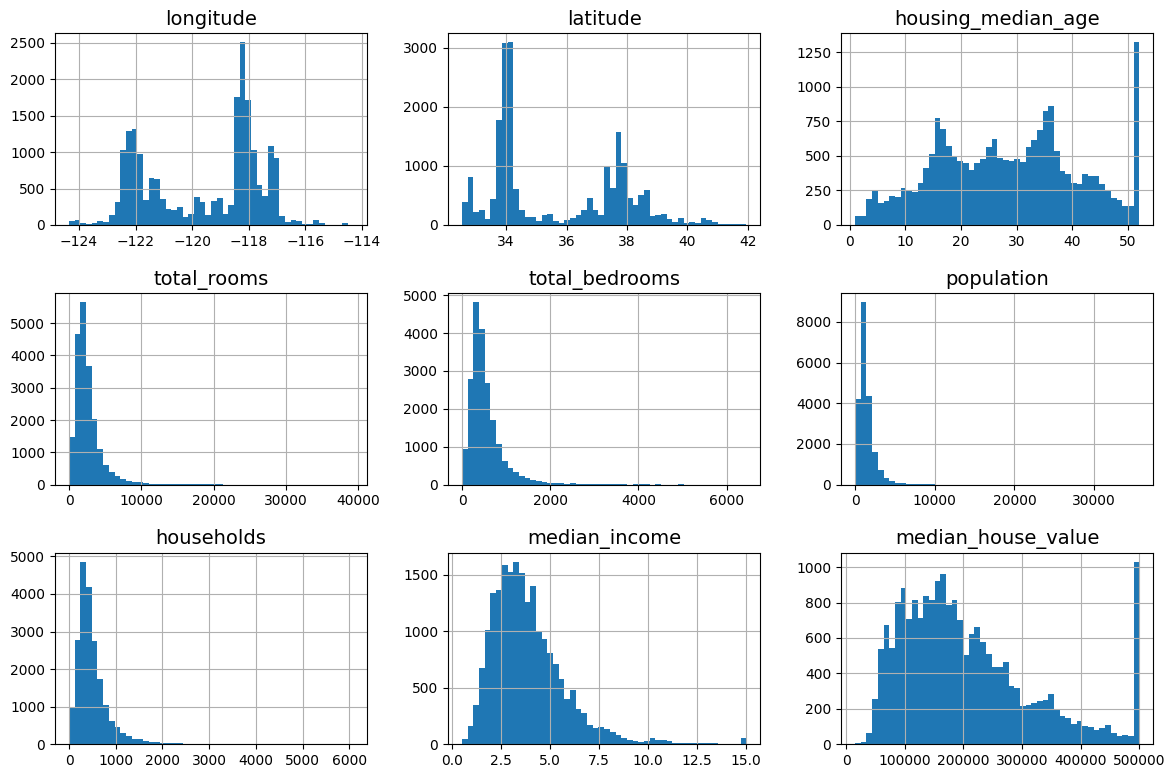

In [89]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

## Create a Test Set

In [90]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [91]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [92]:
len(test_set)

4128

To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed:

In [93]:
np.random.seed(42)

In [94]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [95]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [96]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [97]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [98]:
test_set["total_bedrooms"].isnull().sum()

np.int64(44)

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [99]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


If you prefer simulations over maths, here's how you could get roughly the same result:

In [100]:
# extra code – shows another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

np.float64(0.1071)

In [101]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

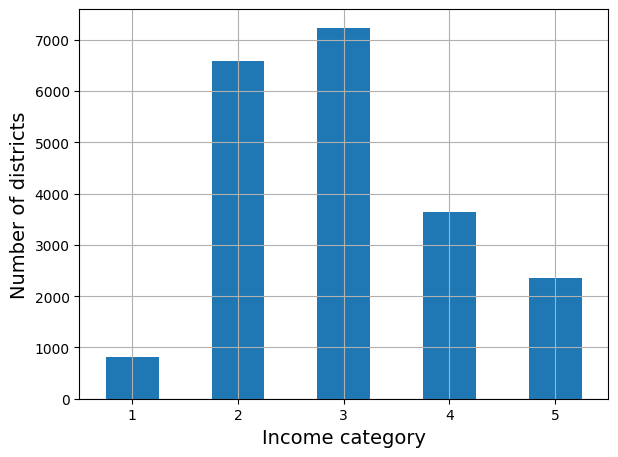

In [102]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")  # extra code
plt.show()

In [103]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [104]:
strat_train_set, strat_test_set = strat_splits[0]

It's much shorter to get a single stratified split:

In [105]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [106]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [107]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [108]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Looking for Correlations

Note: since Pandas 2.0.0, the `numeric_only` argument defaults to `False`, so we need to set it explicitly to True to avoid an error.

In [109]:
corr_matrix = housing.corr(numeric_only=True)

In [110]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


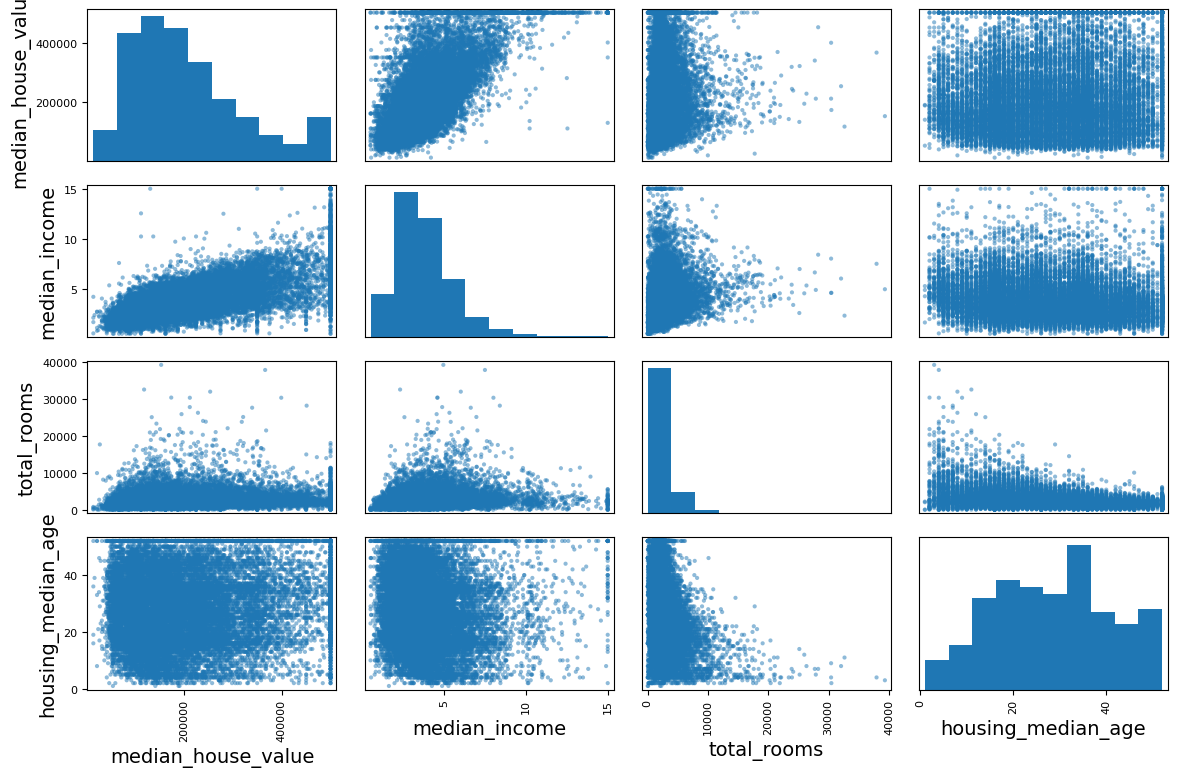

In [111]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

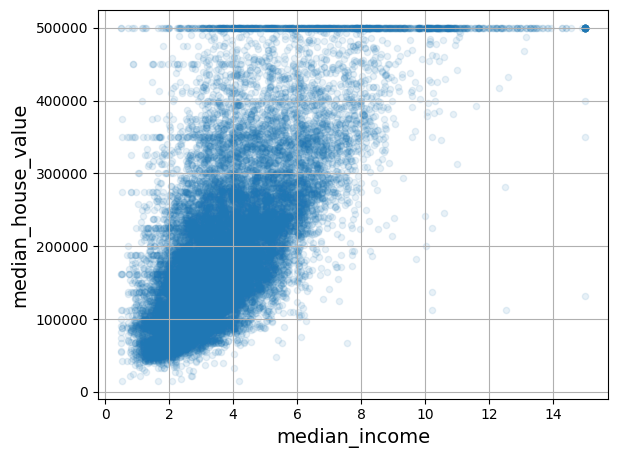

In [112]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

# Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [113]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [114]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [115]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [116]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [117]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head()

<ipython-input-117-b6dffbe9d505>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [118]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")


Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [119]:
housing_num = housing.select_dtypes(include=[np.number])

In [120]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [121]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Check that this is the same as manually computing the median of each attribute:

In [122]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Transform the training set:

In [123]:
X = imputer.transform(housing_num)

In [124]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [125]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [126]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [127]:
imputer.strategy

'median'

In [128]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [129]:
housing_tr.loc[null_rows_idx].head()  # not shown in the book

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


Now let's drop some outliers:

In [130]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [131]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [132]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [133]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [134]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [135]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [136]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [137]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [138]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, you can set `sparse_output=False` when creating the `OneHotEncoder` (note: the `sparse` hyperparameter was renamned to `sparse_output` in Scikit-Learn 1.2):

In [139]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [140]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [141]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [142]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [143]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [144]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [145]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [146]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [147]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)

In [148]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


## Feature Scaling

In [149]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [150]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

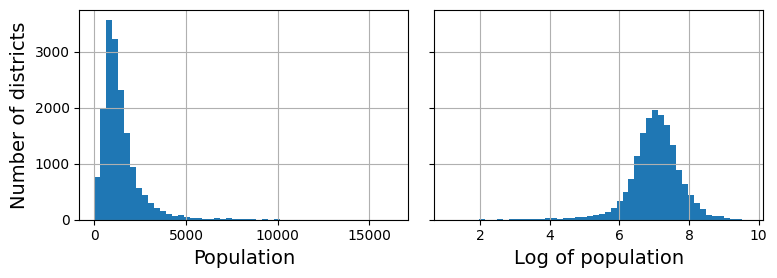

In [151]:
# extra code – this cell generates Figure 2–17
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

In [152]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [153]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [154]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

Now let's build a pipeline to preprocess the numerical attributes:

In [155]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [156]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [157]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [158]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [159]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

In [160]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [161]:
df_housing_num_prepared.head(2)  # extra code

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [162]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [163]:
num_pipeline[1]

StandardScaler()

In [164]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [165]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [166]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [167]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [168]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [169]:
housing_prepared = preprocessing.fit_transform(housing)

In [170]:
# extra code – shows that we can get a DataFrame out if we want
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [172]:
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer # Import FunctionTransformer
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin # Assuming ClusterSimilarity uses these

# Need to define ClusterSimilarity class or ensure it's imported
# Since the traceback doesn't show an error for ClusterSimilarity, it might be defined elsewhere
# or was defined in a previous cell that wasn't included.
# For the sake of making this cell runnable, we'll add a placeholder class.
# Replace this with the actual ClusterSimilarity definition if available.
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1., random_state=42):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None):
        # Placeholder fit method
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X)
        return self

    def transform(self, X):
        # Placeholder transform method
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"cluster_{i}_similarity" for i in range(self.n_clusters)]

# Define the category pipeline, which is used in the ColumnTransformer
# This was likely defined in a previous cell not included in the context,
# but it's needed for the ColumnTransformer definition to work.
# Assuming it was defined as:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [175]:
from sklearn.cluster import KMeans
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [176]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__cluster_0_similarity',
       'geo__cluster_1_similarity', 'geo__cluster_2_similarity',
       'geo__cluster_3_similarity', 'geo__cluster_4_similarity',
       'geo__cluster_5_similarity', 'geo__cluster_6_similarity',
       'geo__cluster_7_similarity', 'geo__cluster_8_similarity',
       'geo__cluster_9_similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [177]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x799...
                                                   'households',
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7993d4aff910>)])),
                ('linearregression', LinearRegression())])

Let's try the full preprocessing pipeline on a few training instances:

In [178]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([246000., 372700., 135700.,  91400., 330900.])

Compare against the actual values:

In [179]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [180]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.3%, -23.0%, 33.4%, -4.9%, -8.5%


**Warning**: In recent versions of Scikit-Learn, you must use `root_mean_squared_error(labels, predictions)` to compute the RMSE, instead of `mean_squared_error(labels, predictions, squared=False)`. The following `try`/`except` block tries to import `root_mean_squared_error`, and if it fails it just defines it.

In [181]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68972.88910758484

In [182]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x799...
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7993d4aff910>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [183]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [184]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [185]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,66573.734600
std,1103.402323
min,64607.896046
25%,66204.731788
50%,66388.272499
75%,66826.257468
max,68532.210664


In [186]:
# extra code – computes the error stats for the linear model
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

,0
count,10.000000
mean,70003.404818
std,4182.188328
min,65504.765753
25%,68172.065831
50%,68743.995249
75%,70344.943988
max,81037.863741


**Warning:** the following cell may take a few minutes to run:

In [187]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [188]:
pd.Series(forest_rmses).describe()

,0
count,10.000000
mean,47038.092799
std,1021.491757
min,45495.976649
25%,46510.418013
50%,47118.719249
75%,47480.519175
max,49140.832210


Let's compare this RMSE measured using cross-validation (the "validation error") with the RMSE measured on the training set (the "training error"):

In [189]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17551.2122500877

The training error is much lower than the validation error, which usually means that the model has overfit the training set. Another possible explanation may be that there's a mismatch between the training data and the validation data, but it's not the case here, since both came from the same dataset that we shuffled and split in two parts.

# Fine-Tune Your Model

## Grid Search

**Warning:** the following cell may take a few minutes to run:

In [190]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

KeyboardInterrupt: 

You can get the full list of hyperparameters available for tuning by looking at `full_pipeline.get_params().keys()`:

In [ ]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

## Randomized Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:

**Warning:** the following cell may take a few minutes to run:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

In [ ]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

**Bonus section: how to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.


Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:

In [ ]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `loguniform()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `loguniform()` does not favor any scale, they are all equally likely:

In [ ]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Analyze the Best Models and Their Errors

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

## Evaluate Your System on the Test Set

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

We can compute a 95% confidence interval for the test RMSE:

In [ ]:
from scipy import stats

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse,
                              confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval


In [ ]:
rmse_lower, rmse_upper

## Model persistence using joblib

Save the final model:

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

Now you can deploy this model to production. For example, the following code could be a script that would run in production:

In [ ]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [ ]:
predictions

You could use pickle instead, but joblib is more efficient.

# Exercise solutions

## 1.

Exercise: _Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best `SVR` predictor perform?_

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [10., 30., 100., 300., 1000.,
                                               3000., 10000., 30000.0]},
        {'svr__kernel': ['rbf'], 'svr__C': [1.0, 3.0, 10., 30., 100., 300.,
                                            1000.0],
         'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svr_pipeline = Pipeline([("preprocessing", preprocessing), ("svr", SVR())])
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7993d4aff910>)])),
                                       ('svr', SVR())]),
             param_grid=[{'svr__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'svr__kernel': ['linear']},
                         {'svr__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error')

The best model achieves the following score (evaluated using 3-fold cross validation):

In [193]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

np.float64(70059.9277356289)

That's much worse than the `RandomForestRegressor` (but to be fair, we trained the model on much less data). Let's check the best hyperparameters found:

In [194]:
grid_search.best_params_

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Exercise: _Try replacing the `GridSearchCV` with a `RandomizedSearchCV`._

**Warning:** the following cell will take several minutes to run. You can specify `verbose=2` when creating the `RandomizedSearchCV` if you want to see the training details.

In [195]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, loguniform

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `loguniform()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': loguniform(20, 200_000),
        'svr__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(svr_pipeline,
                                param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7993d4aff910>)])),
                                             ('svr', SVR())]),
                   n_iter=50,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7993d4b5f850>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7993da3e8f50>,
                                        'svr__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

The best model achieves the following score (evaluated using 3-fold cross validation):

In [196]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

np.float64(56152.053691161)

Now that's really much better, but still far from the `RandomForestRegressor`'s performance. Let's check the best hyperparameters found:

In [197]:
rnd_search.best_params_

{'svr__C': np.float64(157055.10989448498),
 'svr__gamma': np.float64(0.26497040005002437),
 'svr__kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Note that we used the `expon()` distribution for `gamma`, with a scale of 1, so `RandomSearch` mostly searched for values roughly of that scale: about 80% of the samples were between 0.1 and 2.3 (roughly 10% were smaller and 10% were larger):

In [198]:
np.random.seed(42)

s = expon(scale=1).rvs(100_000)  # get 100,000 samples
((s > 0.105) & (s < 2.29)).sum() / 100_000

np.float64(0.80066)

We used the `loguniform()` distribution for `C`, meaning we did not have a clue what the optimal scale of `C` was before running the random search. It explored the range from 20 to 200 just as much as the range from 2,000 to 20,000 or from 20,000 to 200,000.

## 3.

Exercise: _Try adding a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes._

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a `SelectFromModel` transformer based on a `RandomForestRegressor` before the final regressor:

In [199]:
from sklearn.feature_selection import SelectFromModel

selector_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold=0.005)),  # min feature importance
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [200]:
selector_rmses = -cross_val_score(selector_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(selector_rmses).describe()

,0
count,3.000000
mean,56622.643481
std,2272.666703
min,54243.242290
25%,55548.509493
50%,56853.776696
75%,57812.344076
max,58770.911457


Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tuning it using random search or grid search?

## 4.

Exercise: _Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts._

Rather than restrict ourselves to k-Nearest Neighbors regressors, let's create a transformer that accepts any regressor. For this, we can extend the `MetaEstimatorMixin` and have a required `estimator` argument in the constructor. The `fit()` method must work on a clone of this estimator, and it must also save `feature_names_in_`. The `MetaEstimatorMixin` will ensure that `estimator` is listed as a required parameters, and it will update `get_params()` and `set_params()` to make the estimator's hyperparameters available for tuning. Lastly, we create a `get_feature_names_out()` method: the output column name is the ...

Let's ensure it complies to Scikit-Learn's API:

In [203]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import MetaEstimatorMixin, clone
from sklearn.utils.validation import check_array, check_is_fitted # Import check_is_fitted

class FeatureFromRegressor(MetaEstimatorMixin, TransformerMixin, BaseEstimator):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None):
        check_array(X)
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y)
        self.n_features_in_ = self.estimator_.n_features_in_
        if hasattr(self.estimator_, "feature_names_in_"):
            self.feature_names_in_ = self.estimator_.feature_names_in_
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)
        predictions = self.estimator_.predict(X)
        if predictions.ndim == 1:
            predictions = predictions.reshape(-1, 1)
        return predictions

    def get_feature_names_out(self, names=None):
        check_is_fitted(self)
        n_outputs = getattr(self.estimator_, "n_outputs_", 1)
        estimator_class_name = self.estimator_.__class__.__name__
        estimator_short_name = estimator_class_name.lower().replace("_", "")
        return [f"{estimator_short_name}_prediction_{i}"
                for i in range(n_outputs)]

In [204]:
from sklearn.utils.estimator_checks import check_estimator

test_results = check_estimator(FeatureFromRegressor(KNeighborsRegressor()))

Good! Now let's test it:

In [205]:
knn_reg = KNeighborsRegressor(n_neighbors=3, weights="distance")
knn_transformer = FeatureFromRegressor(knn_reg)
geo_features = housing[["latitude", "longitude"]]
knn_transformer.fit_transform(geo_features, housing_labels)

array([[412500.33333333],
       [435250.        ],
       [105100.        ],
       ...,
       [148800.        ],
       [500001.        ],
       [234333.33333333]])

And what does its output feature name look like?

In [206]:
knn_transformer.get_feature_names_out()

['kneighborsregressor_prediction_0']

Okay, now let's include this transformer in our preprocessing pipeline:

In [207]:
from sklearn.base import clone

transformers = [(name, clone(transformer), columns)
                for name, transformer, columns in preprocessing.transformers]
geo_index = [name for name, _, _ in transformers].index("geo")
transformers[geo_index] = ("geo", knn_transformer, ["latitude", "longitude"])

new_geo_preprocessing = ColumnTransformer(transformers)

In [208]:
new_geo_pipeline = Pipeline([
    ('preprocessing', new_geo_preprocessing),
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

In [209]:
new_pipe_rmses = -cross_val_score(new_geo_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(new_pipe_rmses).describe()

,0
count,3.000000
mean,104866.322819
std,2966.688335
min,101535.315061
25%,103687.330297
50%,105839.345534
75%,106531.826698
max,107224.307862


Yikes, that's terrible! Apparently the cluster similarity features were much better. But perhaps we should tune the `KNeighborsRegressor`'s hyperparameters? That's what the next exercise is about.

## 5.

Exercise: _Automatically explore some preparation options using `RandomSearchCV`._

In [210]:
param_distribs = {
    "preprocessing__geo__estimator__n_neighbors": range(1, 30),
    "preprocessing__geo__estimator__weights": ["distance", "uniform"],
    "svr__C": loguniform(20, 200_000),
    "svr__gamma": expon(scale=1.0),
}

new_geo_rnd_search = RandomizedSearchCV(new_geo_pipeline,
                                        param_distributions=param_distribs,
                                        n_iter=50,
                                        cv=3,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=42)
new_geo_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x7993d81e36a0>,
                                                                                                                    func=<function column_ratio at 0x7993d81e02c0>)),
                                                                                               ('standardscaler',
                                                                                                StandardSc...
                   param_distributions={'preprocessing__geo__estimator__n_neighbors': range(1, 30),
                                        'preprocessing__geo__estimator__weights': ['distance',
                                                                                   'uniform'],
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7993d5bbee90>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7993da3605d0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [211]:
new_geo_rnd_search_rmse = -new_geo_rnd_search.best_score_
new_geo_rnd_search_rmse

np.float64(106768.04614723373)

Oh well... at least we tried! It looks like the cluster similarity features are definitely better than the KNN feature. But perhaps you could try having both? And maybe training on the full training set would help as well.

## 6.

Exercise: _Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in_` in the `fit()` method if the input is a DataFrame. This attribute should be a NumPy array of column names. Lastly, implement the `get_feature_names_out()` method: it should have one optional `input_features=None` argument. If passed, the method should check that its length matches `n_features_in_`, and it should match `feature_names_in_` if it is defined, then `input_features` should be returned. If `input_features` is `None`, then the method should return `feature_names_in_` if it is defined or `np.array(["x0", "x1", ...])` with length `n_features_in_` otherwise._

In [212]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, validate_data

class StandardScalerClone(TransformerMixin, BaseEstimator):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = validate_data(self, X, ensure_2d=True)
        self.n_features_in_ = X.shape[1]
        if self.with_mean:
            self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0, ddof=0)
        self.scale_[self.scale_ == 0] = 1  # Avoid division by zero
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, ensure_2d=True, reset=False)
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

    def inverse_transform(self, X):
        check_is_fitted(self)
        X = validate_data(self, X, ensure_2d=True, reset=False)
        return X * self.scale_ + self.mean_

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

Let's test our custom transformer:

In [213]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(StandardScalerClone())

[{'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_cloneable',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_tags_renamed',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_valid_tag_types',
  'exception': None,
  'status': 'passed',
  'expected_to_fail': False,
  'expected_to_fail_reason': 'Check is not expected to fail'},
 {'estimator': StandardScalerClone(),
  'check_name': 'check_estimator_repr',
  'exception': None,
  'status': 'passed',
  'expec

No errors, that's a great start, we respect the Scikit-Learn API.

Now let's ensure the transformation works as expected:

In [214]:
np.random.seed(42)
X = np.random.rand(1000, 3)

scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(X)

assert np.allclose(X_scaled, (X - X.mean(axis=0)) / X.std(axis=0))

How about setting `with_mean=False`?

In [215]:
scaler = StandardScalerClone(with_mean=False)
X_scaled_uncentered = scaler.fit_transform(X)

assert np.allclose(X_scaled_uncentered, X / X.std(axis=0))

And does the inverse work?

In [216]:
scaler = StandardScalerClone()
X_back = scaler.inverse_transform(scaler.fit_transform(X))

assert np.allclose(X, X_back)

How about the feature names out?

In [217]:
assert np.all(scaler.get_feature_names_out() == ["x0", "x1", "x2"])
assert np.all(scaler.get_feature_names_out(["a", "b", "c"]) == ["a", "b", "c"])

And if we fit a DataFrame, are the feature in and out ok?

In [218]:
df = pd.DataFrame({"a": np.random.rand(100), "b": np.random.rand(100)})
scaler = StandardScalerClone()
X_scaled = scaler.fit_transform(df)

assert np.all(scaler.feature_names_in_ == ["a", "b"])
assert np.all(scaler.get_feature_names_out() == ["a", "b"])

All good! That's all for today! 😀